In [3]:
import numpy as np
from tqdm.notebook import tqdm
import pickle
import geopandas as gp

import networkx as nx
import matplotlib.pyplot as plt

In [4]:
df = gp.read_file("station_to_station.geojson")
dfS = gp.read_file("stations.geojson")
dfC = gp.read_file("belgium.geojson") # https://datahub.io/core/geo-countries#resource-geo-countries_zip

In [5]:
SID = df['stationfrom_id'].unique()
n = len(SID)
position = []
name = []
dfS_idx = []
for s in SID:
    DF = dfS.where(dfS.ptcarid==s).dropna()
    dfS_idx.append(DF.index.values[0])
    name.append(DF.commercialmiddlenamefrench.values[0])
    position.append(DF.geometry.values[0])
name = np.array(name,dtype=object)
position = np.array(position, dtype=object)
dfS_idx = np.array(dfS_idx)

c:\users\antoine\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Antoine\AppData\Local\Temp/ipykernel_12232/3684489268.py:12: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  position = np.array(position, dtype=object)


In [6]:
A = np.ones((n,n)) * np.inf
D = np.zeros((n,n))
for s in df.iterrows():
    p = s[1].geometry
    A[np.where(SID==s[1].stationfrom_id)[0], np.where(SID==s[1].stationto_id)[0]] = s[1].length
    D[np.where(SID==s[1].stationfrom_id)[0], np.where(SID==s[1].stationto_id)[0]] = 1

380


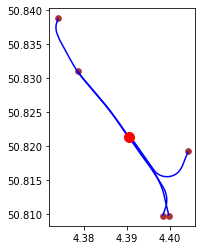

In [7]:
s = 14
print(SID[s])
base = dfS.where(dfS.ptcarid==str(SID[s])).dropna().plot(color='red', markersize=100, zorder=10)
DF = df.where(df.stationfrom_id==str(SID[s])).dropna()
DF.plot(ax=base, color='blue')
for s2 in DF.iterrows():
    dfS.where(dfS.ptcarid==str(s2[1].stationto_id)).dropna().plot(ax=base, color='#AA3333', markersize=32)

In [8]:
# Source: slides Lecture 4 : K-core decomposition
def k_core(A):
    n = len(A)
    n_pruned = 0
    deg = np.zeros(n)
    pruned = np.zeros(n)
    neigh = []
    k = 1
    shells = []
    
    for i in range(n): 
        N = [j for j in range(n) if A[i,j] < np.inf]
        deg[i] = len(N)
        neigh.append(N)
        
    
    while n_pruned < n:
        to_prune = list([i for i in range(n) if deg[i] == k])
        k_shell = []
        while len(to_prune) > 0:
            i = to_prune.pop(0)
            for j in neigh[i]:
                if not pruned[j]:
                    deg[j] -= 1
                    if deg[j] == k: to_prune.append(j)
            pruned[i] = True
            k_shell.append(i)
            n_pruned += 1
        shells.append(k_shell)
        k += 1
        
    return shells

In [9]:
shells = k_core(A)
values = np.zeros(len(dfS))
radius = np.zeros(len(dfS))
for i in range(len(shells)):
    
    for s in shells[i]:
        idx = np.where(dfS==str(SID[s]))[0]
        values[idx] = i
        radius[idx] = i*i;

ks_df = dfS.copy()
ks_df['shell'] = values

In [10]:
for shell in shells[::-1][:2]:
    for s in shell:
        print(dfS.where(dfS.ptcarid==str(SID[s])).dropna().commercialmiddlenamefrench)
    print('-------------------------------------------------------------')

658    Bruxelles-Midi
Name: commercialmiddlenamefrench, dtype: object
1280    Schaerbeek
Name: commercialmiddlenamefrench, dtype: object
489    Diegem
Name: commercialmiddlenamefrench, dtype: object
842    Brussels Airport
Name: commercialmiddlenamefrench, dtype: object
497    Bruxelles-Ouest
Name: commercialmiddlenamefrench, dtype: object
554    Haren
Name: commercialmiddlenamefrench, dtype: object
287    Anderlecht
Name: commercialmiddlenamefrench, dtype: object
667    Malines
Name: commercialmiddlenamefrench, dtype: object
645    Gand-Saint-Pierre
Name: commercialmiddlenamefrench, dtype: object
158    Melle
Name: commercialmiddlenamefrench, dtype: object
-------------------------------------------------------------
1119    Sint-Mariaburg
Name: commercialmiddlenamefrench, dtype: object
624    Denderleeuw
Name: commercialmiddlenamefrench, dtype: object
590    Anvers-Noorderdokken
Name: commercialmiddlenamefrench, dtype: object
275    Ougrée
Name: commercialmiddlenamefrench, dtype: obj

In [11]:
ks_df.shell.unique()

array([0., 1., 2., 3.])

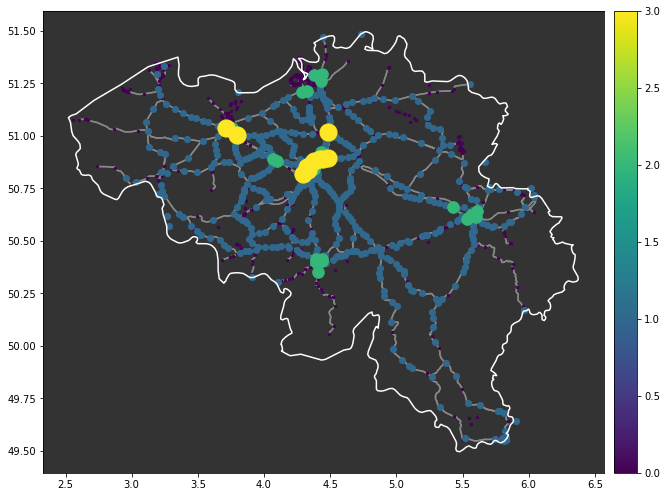

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
CM = cm.get_cmap('viridis', len(shells))
base = None

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
for i in range(len(shells)):
    DF =  ks_df.where(ks_df.shell==i).dropna()
    
    base = DF.plot(markersize=6+32*i*i, color=CM.colors[i], ax=ax)
    #if i == 3:
    #    for x, y, label in zip(DF.geometry.x, DF.geometry.y, DF.commercialmiddlenamefrench):
    #        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='white')   
    
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=ks_df.shell.min(), vmax=ks_df.shell.max()))
cb = plt.colorbar(sm, pad=0.01)
ax.set_facecolor('#333333')
plt.show()

In [13]:
import community.community_louvain as community_louvain
G = nx.from_numpy_matrix(D)

communities = community_louvain.best_partition(G)

In [14]:
comm_df = dfS.copy()
comm = np.zeros(len(dfS))
for s in communities:
    idx = np.where(dfS==SID[s])[0]
    comm[idx] = communities[s]
comm_df['comm'] = comm


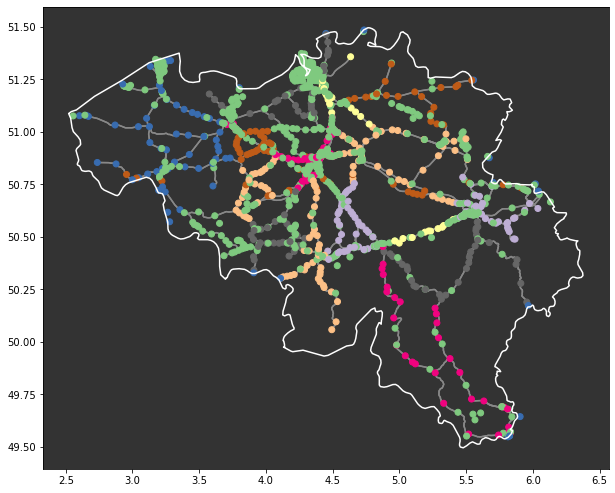

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
comm_df.plot('comm', cmap='Accent', ax=ax)
ax.set_facecolor('#333333')
plt.show()

In [16]:
bc_df = dfS.copy()
bc = np.zeros(len(dfS))
dc = nx.degree_centrality(G)
for s in dc:
    idx = np.where(dfS==SID[s])[0]
    bc[idx] = dc[s]
bc_df['bc'] = bc


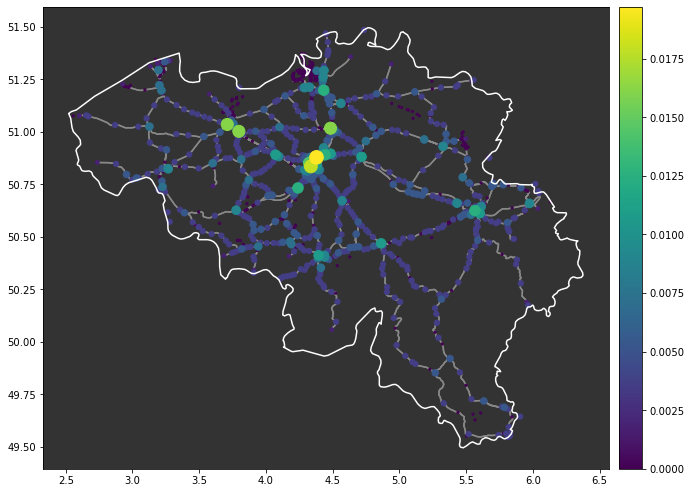

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
idx = np.argsort(bc)
BC = bc[idx]

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
bc_df.iloc[idx].plot('bc', markersize=5+bc[idx]**1.2*2*10e3, ax=ax)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=bc_df.bc.min(), vmax=bc_df.bc.max()))
cb = plt.colorbar(sm, pad=0.01)
ax.set_facecolor('#333333')
plt.show()

# Dijkstra shortest path

In [18]:
from queue import PriorityQueue
A_sp = np.copy(A)
A_sp[A_sp == np.inf] = 0
G = nx.from_numpy_matrix(A_sp)
SID = SID.astype(np.int)


C:\Users\Antoine\AppData\Local\Temp/ipykernel_12232/3279331142.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SID = SID.astype(np.int)


In [19]:
def dijkstra(G, s, outputGif=False):
    i=0
    dist = np.ones((G.number_of_nodes()))*np.inf
    prev = -1*np.empty((G.number_of_nodes()), dtype=np.int)
    visited = np.zeros((G.number_of_nodes()))
    
    pq = PriorityQueue()
    pq.put((0, s))
    dist[s] = 0; prev[s] = s
    visited[s] = True
    
    if outputGif:
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 8.5)
        ax.set_facecolor('#333333')
        dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')

    while not pq.empty():
        d, v = pq.get()
        for u in G.neighbors(v):
            weight = G[u][v]['weight']
            if not visited[u]:
                if d+weight < dist[u]:
                    pq.put((d+weight, u))
                    dist[u]=d+weight
                    prev[u] = v
                    i+=1
                    if outputGif:
                        plot_dijkstra_gif(u, v, i, True, ax=ax)
    if outputGif:
        ax.close()
    return dist, prev

In [20]:
def node_of(SID, df, station_name):
    """Get the node number of the graph

    Args:
        SID (np.array): The array containing the Station Ids.
        df (gpd.dataframe): GeoDatafram
        station_name (str): 

    Returns:
        int: number of the node.
    """
    station_id = int(df.loc[df['stationto_name'] == station_name]['stationto_id'].values[0])
    return np.where(SID == station_id)[0][0]

def name_of(SID, df, node_id):
    """
    Inverse function of node_of().
    """
    station_id = SID[node_id]
    return df.loc[df['stationto_id'] == station_id]['stationto_name'].values[0]

In [21]:
def explore_dijkstra(source, dest, prev):
    """
    the same as df.explore(), but only output the shortest path.
    """
    keep=[]
    u = dest
    while u != source:
        v = prev[u]
        q1 = df.query(f"stationfrom_id == '{SID[v]}' and stationto_id=='{SID[u]}'")
        q2 = df.query(f"stationfrom_id == '{SID[u]}' and stationto_id=='{SID[v]}'")
        keep.append(q1.first_valid_index())
        keep.append(q2.first_valid_index())
        u = prev[u]
    return df.iloc[keep].explore(cmap='OrRd', tiles="https://tile.openstreetmap.be/osmbe/{z}/{x}/{y}.png", 
            attr="Tiles courtesy of <a href=\"https://geo6.be/\">GEO-6</a> - github/jbelien/openstreetmap-carto-be",
            style_kwds={'weight':4}
        )

def plot_dijkstra_gif(u, v, i=None, gif_mode=False, ax=None):
    q1 = df.query(f"stationfrom_id == '{SID[u]}' and stationto_id=='{SID[v]}'")
    q1.plot(ax=ax)
    plt.savefig(f"gif2/{i}.png")


"""
Exemple for Shortest path from LLN to Koksijde
"""
start = 'LOUVAIN-LA-N'
stop = 'KOKSIJDE'

start_node = node_of(SID, df, start)
stop_node = node_of(SID, df, stop)

dist, prev = dijkstra(G, start_node, outputGif=False)
explore_dijkstra(start_node, stop_node, prev)

C:\Users\Antoine\AppData\Local\Temp/ipykernel_12232/3586230649.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev = -1*np.empty((G.number_of_nodes()), dtype=np.int)


## Generating and optimizing the output gif

In [22]:
#import os
#import imageio
#from pygifsicle import optimize
#
#filenames = [f"{i}.png" for i in range(1, 593)]
#with imageio.get_writer('dsp_lln.gif', mode='I') as writer:
#    for filename in filenames:
#        image = imageio.imread("gif2/" + filename)
#        writer.append_data(image)
#
#optimize("dsp_lln.gif")

# Stations by increasing mean distance order

In [23]:
mean_dist = np.ones(n) * np.inf
for i in range(n):
    dist, prev = dijkstra(G, i, outputGif=False)
    mean_dist[i] = dist.mean()

C:\Users\Antoine\AppData\Local\Temp/ipykernel_12232/3586230649.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev = -1*np.empty((G.number_of_nodes()), dtype=np.int)


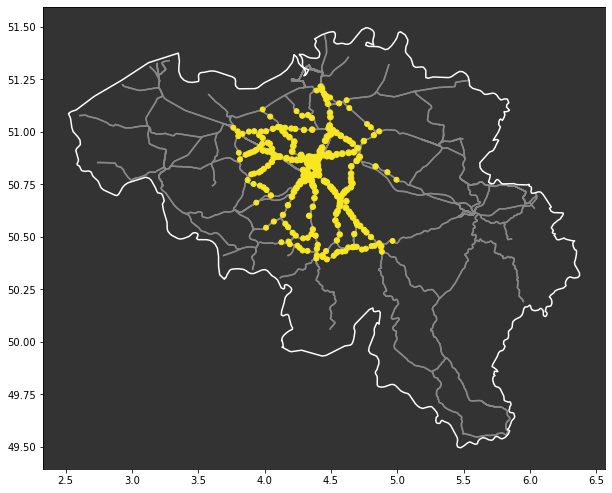

In [24]:
idx = mean_dist.argsort()[:250][::-1]
IDX = []
for j in idx:
    I=dfS.where(dfS.ptcarid==str(SID[j])).dropna().index.values[0]
    IDX.append(I)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
dfS.iloc[IDX].dropna().plot(color='#F8E621', markersize=0.00001*(mean_dist.max()-mean_dist[idx])**3, ax=ax)
ax.set_facecolor('#333333')

## GIF

In [25]:
#sorted_ids = mean_dist.argsort()
#
#for i in range(1, n):
#    idx = mean_dist.argsort()[:i][::-1]
#    IDX = []
#    for j in idx:
#        I=dfS.where(dfS.ptcarid==str(SID[j])).dropna().index.values[0]
#        IDX.append(I)
#
#    fig, ax = plt.subplots()
#    fig.set_size_inches(18.5, 8.5)
#
#    df.plot(ax=ax, color='#888888', zorder=0)
#    dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
#    dfS.iloc[IDX].dropna().plot(color='#F8E621', markersize=0.00001*(mean_dist.max()-mean_dist[idx])**3, ax=ax)
#    ax.set_facecolor('#333333')
#
#    plt.savefig(f"dist_gif/{i}.png")
#    plt.close()

In [26]:
#filenames = [f"{i}.png" for i in range(1, 558)]
#with imageio.get_writer('dist.gif', mode='I', fps=40) as writer:
#    for filename in filenames:
#        image = imageio.imread("dist_gif/" + filename)
#        writer.append_data(image)
#
#optimize("dist.gif")

# Influence on the distances by removing the best node in terms of degree centrality

In [27]:
idx = mean_dist.argsort()[:50][::-1]
to_remove = []
for j in idx:
    I=dfS.where(dfS.ptcarid==str(SID[j])).dropna().index.values[0]
    to_remove.append(dfS.iloc[I].ptcarid)
    
to_keep = []
for i in range(len(SID)):
    to_keep.append(i not in to_remove)

In [28]:
SID = df['stationfrom_id'].unique()
n = len(SID)

A2 = np.ones((n,n)) * np.inf
D2 = np.zeros((n,n))
for s in df.iterrows():
    p = s[1].geometry
    if s[1].stationfrom_id not in to_remove and s[1].stationto_id not in to_remove:
        A2[np.where(SID==s[1].stationfrom_id)[0], np.where(SID==s[1].stationto_id)[0]] = s[1].length
        D2[np.where(SID==s[1].stationfrom_id)[0], np.where(SID==s[1].stationto_id)[0]] = 1

In [29]:
A_sp2 = np.copy(A2)
A_sp2[A_sp2 == np.inf] = 0
#print(A[2])
G2 = nx.from_numpy_matrix(A_sp2)

In [30]:
dist, prev = dijkstra(G, start_node, outputGif=False)
dist.mean()

C:\Users\Antoine\AppData\Local\Temp/ipykernel_12232/3586230649.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev = -1*np.empty((G.number_of_nodes()), dtype=np.int)


77.00645092451579

In [31]:
dist, prev = dijkstra(G2, start_node, outputGif=False)
dist[dist!=np.inf].mean()

C:\Users\Antoine\AppData\Local\Temp/ipykernel_12232/3586230649.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev = -1*np.empty((G.number_of_nodes()), dtype=np.int)


94.08585169566157

In [32]:
bc_df2 = dfS.copy()
bc2 = np.zeros(len(dfS))
dc2 = nx.degree_centrality(G2)
for s in dc2:
    idx = np.where(dfS==SID[s])[0]
    bc2[idx] = dc2[s]
bc_df2['bc'] = bc2

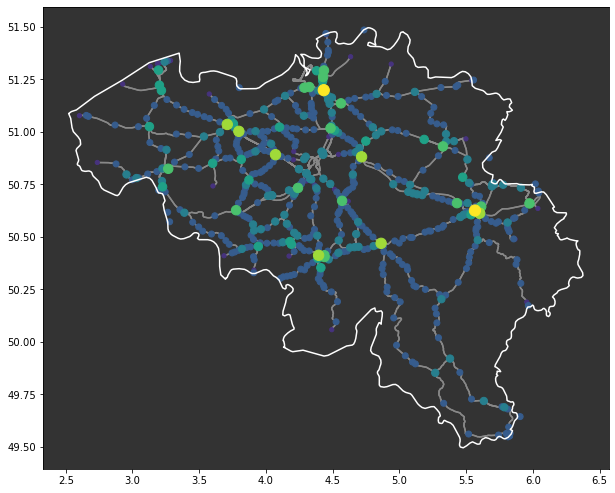

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
idx = np.argsort(bc2)
BC = bc2[idx]

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
bc_df2.iloc[idx].plot('bc', markersize=bc2[idx]*10e3, ax=ax)
ax.set_facecolor('#333333')
plt.show()

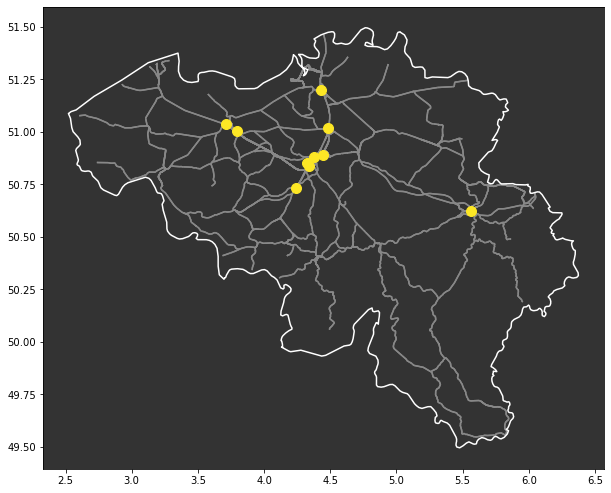

In [34]:
idx = bc.argsort()[::-1][:10]
    
    
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
bc_df.iloc[idx].plot(ax=ax, color='#FDE725', markersize=100)
ax.set_facecolor('#333333')
plt.show()

# Influence Maxization Problem

In [35]:
def ICM(A, A0, p=0.5, N=1000, weighted=False, return_vec = False, snapshots=False, snap_delay=1):
    r = 0
    n = len(A)
    vec = np.zeros(1000)
    max_t = 0
    times = np.zeros(len(dfS))
    
    for k in range(N):
        t = 0
        new_A = set(A0)
        a0 = set(A0)
        while len(new_A) > 0:
            buf = set()
            for i in new_A:
                for j in range(n):
                    if weighted: p = A[j][i] / A[j].sum()
                    if i != j and A[i][j] > 0 and j not in a0 and np.random.uniform(0,1) < p:
                        buf.add(j)
                        a0.add(j)
                        times[dfS_idx[j]]=t+1
            new_A = set(buf)
            r += len(new_A)
            
            if snapshots:
                fig, ax = plt.subplots()
                fig.set_size_inches(18.5, 8.5)

                df.plot(ax=ax, color='#888888', zorder=0)
                dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
                dfS.iloc[dfS_idx[list(a0)]].dropna().plot(color='#F8E621', markersize=100, ax=ax)
                ax.set_facecolor('#333333')
                plt.show()
            
            t += 1
            max_t = max(max_t, t)
            vec[t] += len(new_A)
            
            
    if return_vec: 
        for i in range(1,max_t+1):
            vec[i] += vec[i-1]
        return vec[:max_t+1] / N
    return r / N


In [36]:
def generate_graph(nodes, A, p=0.5):
    n = len(nodes)
    keys = list(nodes)
    
    G=nx.Graph()
    
    G.add_nodes_from(nodes)

    for i in range(n):
        for j in range(i,n):
            if i != j and A[i][j] > 0 and np.random.uniform(0,1) < p: 
                G.add_edges_from([(keys[i], keys[j], {'weight': A[i][j]})])
                
    return G

def influence_function(x, A0):
    keys = list(x)
    nodes = set(A0)
    a0 = set(A0)
    r = 0
    
    while len(nodes) > 0:
        n = nodes.pop()
        a0.add(n)
        r += 1
        neigh = set([keys.index(j) for j in x.neighbors(keys[n])])
        for i in neigh-a0:
            nodes.add(i)
    return r
            
        

def Influence_Maximization(A, k, nodes, weighted=False, A0=None, p=0.5, N=100):
    n = len(A)
    V = set(range(n))
    X = [generate_graph(nodes, A, p=p) for _ in range(N)]
    if A0 == None: A0 = set()
    
    while len(A0) < k:
        best = (-1,0)
        for i in V-A0:
            v = 0
            for x in X:                
                v += influence_function(x,A0.union([i]))
                
            if v > best[1]: best = (i,v)
        A0.add(best[0])
    
    return A0
    
    
    

{166, 521, 44, 172, 14, 84, 312, 441, 508, 30}
['Liège-Guillemins' 'Anvers-Berchem' 'Melsele' 'Marchienne-au-Pont'
 'Etterbeek' 'Schaerbeek' 'Namur' 'Malines' 'Gand-Saint-Pierre'
 'Bruxelles-Midi']


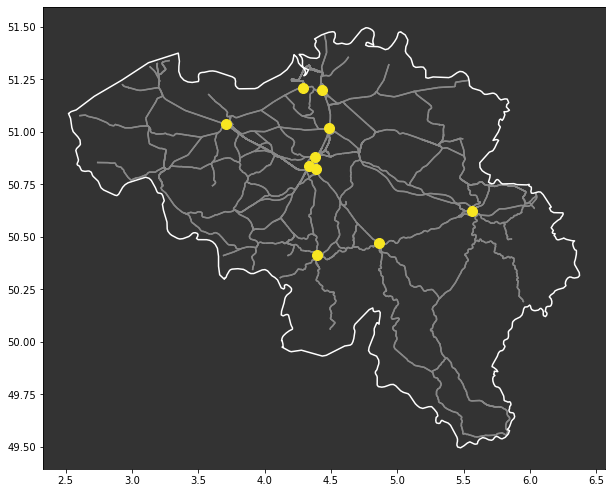

In [37]:
k = 10
p = 0.1
def make_greedy_set(A, k, p, nodes, N=100):
    return Influence_Maximization(A, k, nodes, p=p, N=N)

I = make_greedy_set(A_sp,k,p,SID)
print(I)
ICM(A_sp, I, N=1, p=p, return_vec=True, snapshots=False)

print(name[list(I)])

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
dfS.iloc[dfS_idx[list(I)]].dropna().plot(color='#F8E621', markersize=100, ax=ax)
ax.set_facecolor('#333333')

{166, 521, 365, 497, 147, 84, 535, 441, 508, 30}
['Liège-Guillemins' 'Anvers-Berchem' 'Bruxelles-Ouest' 'Hal' 'Diegem'
 'Schaerbeek' 'Melle' 'Malines' 'Gand-Saint-Pierre' 'Bruxelles-Midi']


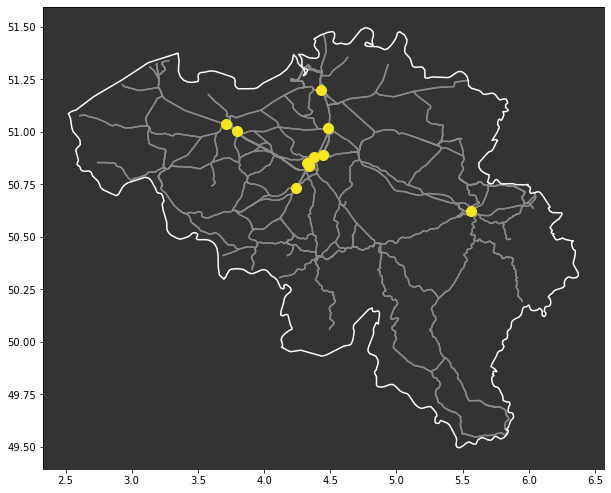

In [38]:
k = 10
p = 0.5

def make_best_deg_set(A,k):
    n = len(A)
    I = set([])
    U = set(range(n))-I
    
    deg = np.zeros(n)
    for i in range(n):
        deg[i] = (A[i] != 0).sum()
        
    for _ in range(k):
        best = (-1,0)
        for i in U:
            if deg[i] >= best[1]: best = (i,deg[i])
        I.add(best[0])
        U = U - I
    return I
    

I=make_best_deg_set(A_sp,k)
print(I)
ICM(A_sp, I, N=1, p=p, return_vec=True, snapshots=False)

print(name[list(I)])

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
dfS.iloc[dfS_idx[list(I)]].dropna().plot(color='#F8E621', markersize=100, ax=ax)
ax.set_facecolor('#333333')

{387, 549, 327, 234, 464, 19, 372, 150, 504, 122}
['Florenville' 'Genk' 'Huy' 'Jette' 'Bissegem' 'Sint-Joris-Weert'
 'Roulers' 'Turnhout' 'Pecrot' 'Péruwelz']


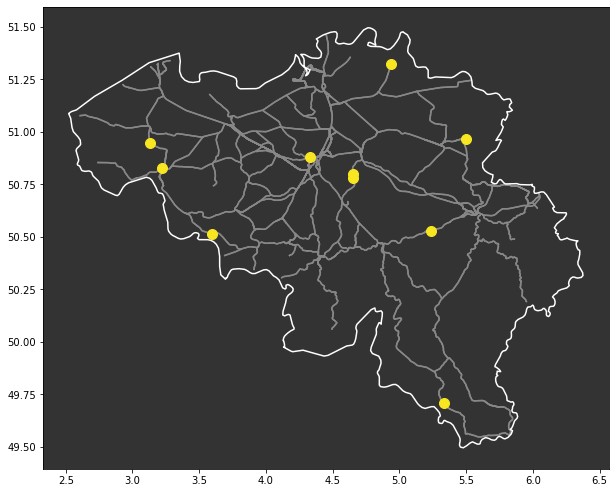

In [39]:
def make_random_set(A,k):
    n = len(A)
    I = set()
    U = set(range(n))
    for _ in range(k):
        u = np.random.choice(list(U))
        U = U - set([u])
        I.add(u)
    return I
    
I=make_random_set(A_sp,k)
print(I)
ICM(A_sp, I, N=1, p=p, return_vec=True)

print(name[list(I)])

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

df.plot(ax=ax, color='#888888', zorder=0)
dfC.where(dfC.ADMIN=='Belgium').dropna().geometry.boundary.plot(ax=ax, color='white')
dfS.iloc[dfS_idx[list(I)]].dropna().plot(color='#F8E621', markersize=100, ax=ax)
ax.set_facecolor('#333333')

{128, 535, 521, 172, 84, 55, 312, 441, 509, 30}
{166, 521, 365, 497, 147, 84, 535, 441, 508, 30}


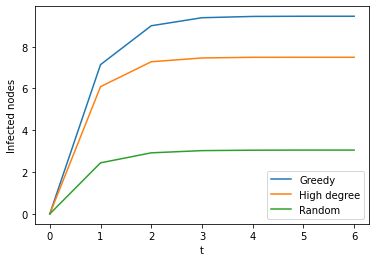

In [41]:
p = 0.1
k = 10

I = make_greedy_set(A_sp,k,p,SID)
print(I)
vec = ICM(A_sp, I, N=1000, p=p, return_vec=True)
plt.plot(range(len(vec)), vec)

I = make_best_deg_set(A_sp,k)
print(I)
vec = ICM(A_sp, I, N=1000, p=p, return_vec=True)
plt.plot(range(len(vec)), vec)

I = make_random_set(A_sp,k)
vec = ICM(A_sp, I, N=1000, p=p, return_vec=True)
plt.plot(range(len(vec)), vec)

plt.legend(['Greedy', 'High degree', 'Random'])
plt.xlabel('t')
plt.ylabel('Infected nodes')
plt.show()